
# Group analysis with MNE-Python


The aim of this lecture is to show you how to do group analysis
with MNE-Python.

    Authors: Britta Westner, Alexandre Gramfort, Denis A. Engemann, Mainak Jas, Hicham Janati

    License: BSD (3-clause)
   

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import mne

mne.set_log_level('error')

# Change the following path to where the folder with the extra data is on your disk:
extra_path = os.path.expanduser('~/Documents/teaching/practical_meeg_2022_data/extra_data_mne')
evokeds_path = os.path.join(extra_path, 'group_analysis/')

Let's check if setting the path worked and if the data is there:

In [27]:
# ls $evokeds_path

## Datasets

We have here the evoked data for all but 1 participant. That one dataset had some issues with the triggers that would have needed fixing to be read into MNE-Python, so here we just discard it (dataset # 10).

In [28]:
datasets = ['sub-%02d' % ii for ii in range(1, 17) if ii not in [10]]
datasets

['sub-01',
 'sub-02',
 'sub-03',
 'sub-04',
 'sub-05',
 'sub-06',
 'sub-07',
 'sub-08',
 'sub-09',
 'sub-11',
 'sub-12',
 'sub-13',
 'sub-14',
 'sub-15',
 'sub-16']

## Let's first look at our different datasets

We can look at the datasets one-by-one:

In [29]:
subject = 'sub-02'
fname = os.path.join(evokeds_path, ('%s_list-ave.fif' % subject))
evokeds = mne.read_evokeds(fname, verbose=False)
evokeds

[<Evoked | 'famous' (average, N=48), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>,
 <Evoked | 'unfamiliar' (average, N=49), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>,
 <Evoked | 'scrambled' (average, N=49), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>]

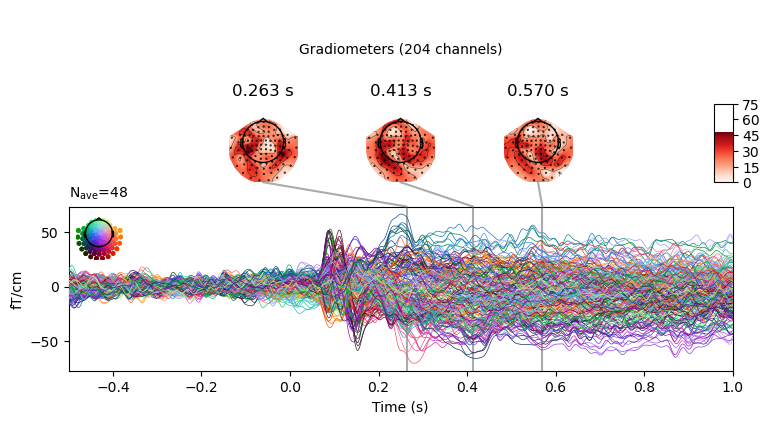

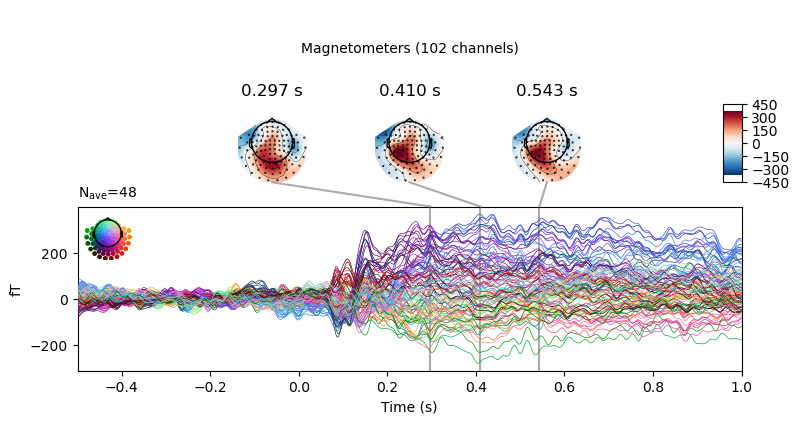

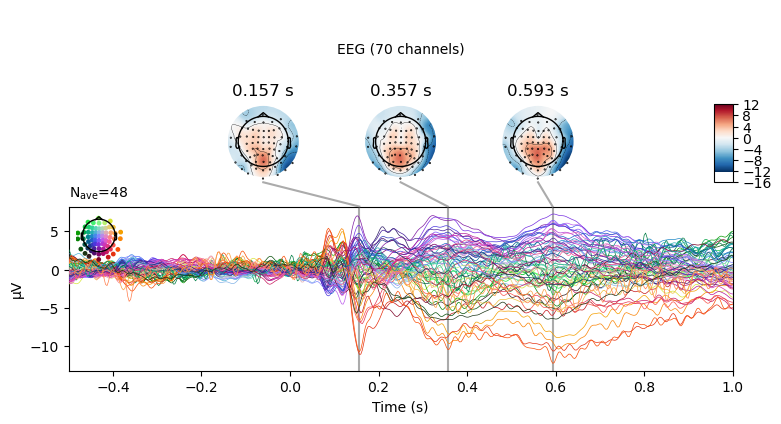

[<Figure size 800x420 with 7 Axes>,
 <Figure size 800x420 with 7 Axes>,
 <Figure size 800x420 with 7 Axes>]

In [30]:
evokeds[0].plot_joint()

We can also loop over all datasets to get an overview and to see if there are any datasets
that look problematic.

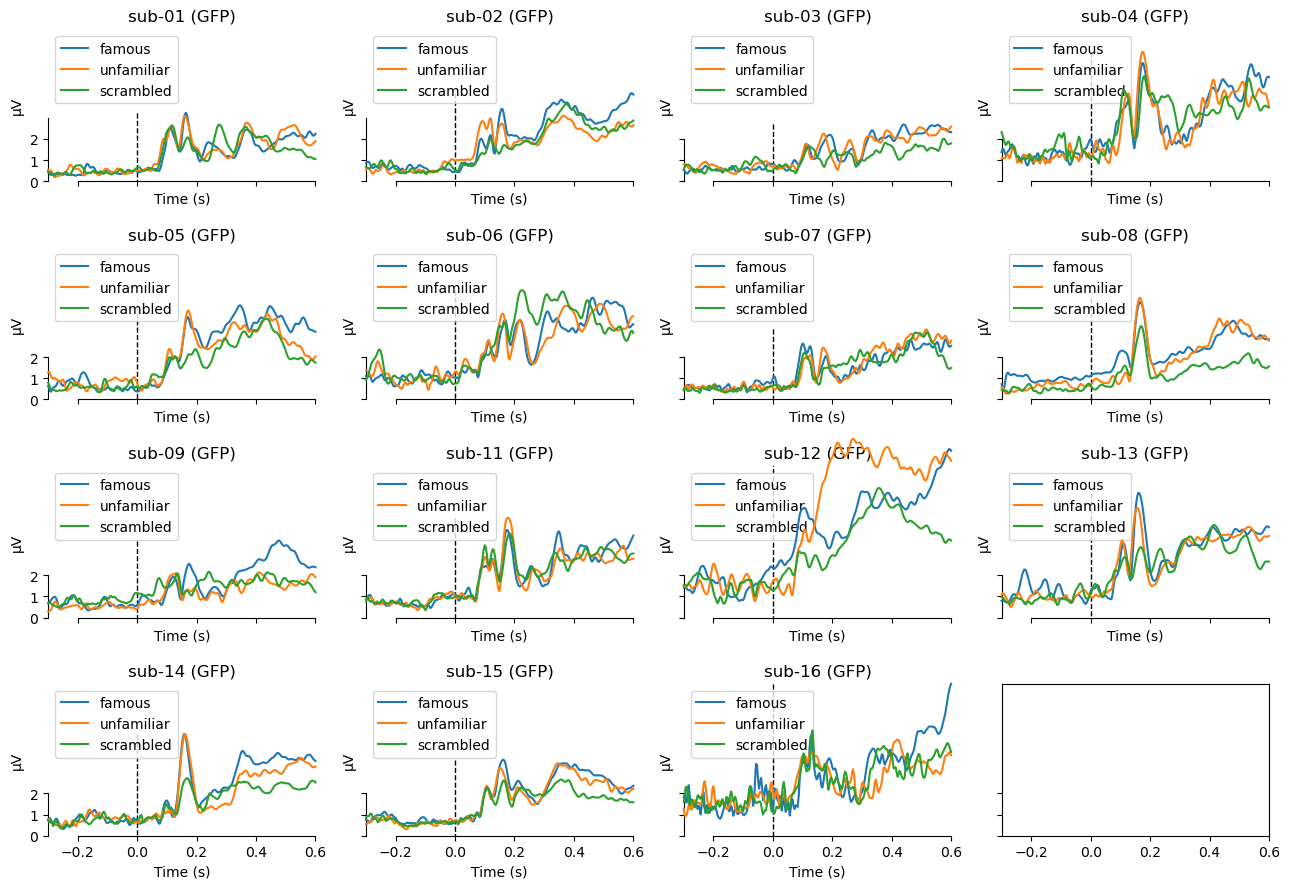

In [31]:
ch_type = 'eeg'  # we pick the EEG channels here
conditions = ['famous', 'unfamiliar', 'scrambled']

f, axes = plt.subplots(4, 4, figsize=(13, 9), sharex=True, sharey=True)

for ax, subject in zip(axes.ravel(), datasets):
    evokeds_dict = dict()
    fname = os.path.join(evokeds_path, ('%s_list-ave.fif' % subject))
    evokeds = mne.read_evokeds(fname)
    evokeds = [ev for ev in evokeds if ev.comment in conditions]
    for condition, ev in zip(conditions, evokeds):
        evokeds_dict[condition] = ev.crop(tmin=-0.3, tmax=0.6)
    mne.viz.plot_compare_evokeds(evokeds_dict, picks=ch_type, show=False,
                                 axes=ax, title=subject)

plt.tight_layout()

<div class='alert alert-success'>
    <b>EXERCISE</b>:
     <ul>
      <li>Compute the same type of GFP plots for MEG Magnetometers</li>
      <li>Do you see any problematic datasets?</li>
    </ul>
</div>

## Read all data and compute contrast

Next we will read in all datasets and append them to _one list_:

In [32]:

evokeds_list = []

for subject in datasets:
    fname = os.path.join(evokeds_path, ('%s_list-ave.fif' % subject))
    evokeds = mne.read_evokeds(fname)
    evokeds = [ev for ev in evokeds if ev.comment in ['famous', 'scrambled']]
    evokeds_list.append(evokeds)

evokeds_list

[[<Evoked | 'famous' (average, N=49), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>,
  <Evoked | 'scrambled' (average, N=50), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>],
 [<Evoked | 'famous' (average, N=48), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>,
  <Evoked | 'scrambled' (average, N=49), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>],
 [<Evoked | 'famous' (average, N=50), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>,
  <Evoked | 'scrambled' (average, N=45), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>],
 [<Evoked | 'famous' (average, N=44), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>,
  <Evoked | 'scrambled' (average, N=47), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>],
 [<Evoked | 'famous' (average, N=49), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>,
  <Evoked | 'scrambled' (average, N=49), -0.5 – 1 sec, baseline -0.5 – 0 sec, 376 ch, ~8.3 MB>],
 [<Evoked | 'famous' (average, N=48), -0.5 – 1 sec

From here, we can compute the contrast, e.g. between _famous_ and _scrambled_. We can also plot this contrast.

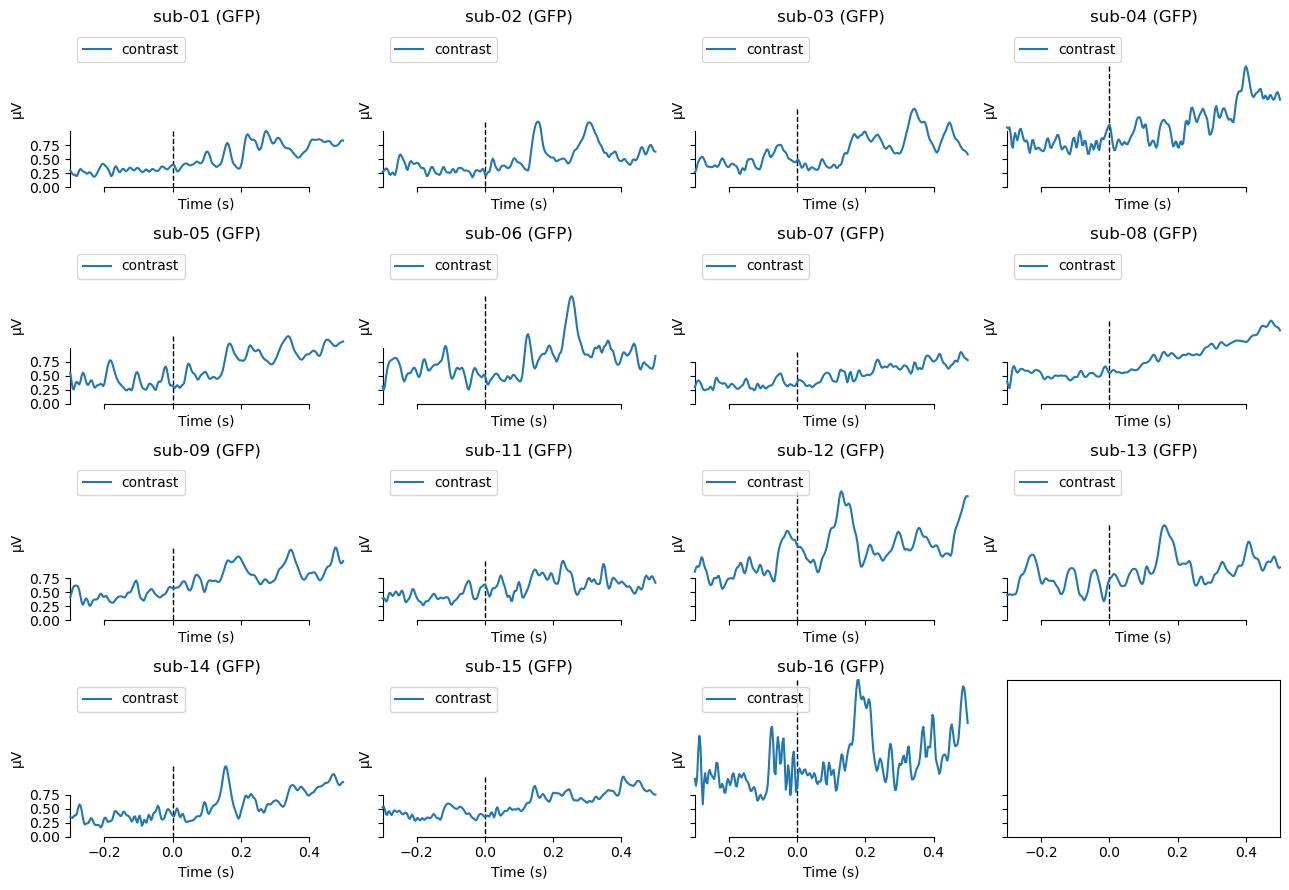

In [33]:
contrast_list = []
f, axes = plt.subplots(4, 4, figsize=(13, 9), sharex=True, sharey=True)

for ax, subject, evokeds in zip(axes.ravel(), datasets, evokeds_list):
    contrast = mne.combine_evoked(evokeds, weights=[0.5, -0.5]).crop(-0.3, 0.5)
    contrast.comment = 'contrast'
    contrast_list.append(contrast)
    mne.viz.plot_compare_evokeds(contrast, picks=ch_type, show=False,
                                 axes=ax, title=subject)
plt.tight_layout()

In [34]:
contrast_list

[<Evoked | 'contrast' (average, N=98.98989898989899), -0.3 – 0.5 sec, baseline -0.5 – 0 sec (baseline period was cropped after baseline correction), 376 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=96.9896907216495), -0.3 – 0.5 sec, baseline -0.5 – 0 sec (baseline period was cropped after baseline correction), 376 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=94.73684210526315), -0.3 – 0.5 sec, baseline -0.5 – 0 sec (baseline period was cropped after baseline correction), 376 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=90.9010989010989), -0.3 – 0.5 sec, baseline -0.5 – 0 sec (baseline period was cropped after baseline correction), 376 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=98.00000000000001), -0.3 – 0.5 sec, baseline -0.5 – 0 sec (baseline period was cropped after baseline correction), 376 ch, ~7.7 MB>,
 <Evoked | 'contrast' (average, N=94.98947368421052), -0.3 – 0.5 sec, baseline -0.5 – 0 sec (baseline period was cropped after baseline correction), 376 ch, ~7.7 MB>,


### Look at grand averages

Grand averages are obtained by averaging the sensor space data.

In [35]:
mne.grand_average?

Signature: mne.grand_average(all_inst, interpolate_bads=True, drop_bads=True)
Docstring:
Make grand average of a list of Evoked or AverageTFR data.

For :class:`mne.Evoked` data, the function interpolates bad channels based
on the ``interpolate_bads`` parameter. If ``interpolate_bads`` is True,
the grand average file will contain good channels and the bad channels
interpolated from the good MEG/EEG channels.
For :class:`mne.time_frequency.AverageTFR` data, the function takes the
subset of channels not marked as bad in any of the instances.

The ``grand_average.nave`` attribute will be equal to the number
of evoked datasets used to calculate the grand average.

.. note:: A grand average evoked should not be used for source
          localization.

Parameters
----------
all_inst : list of Evoked or AverageTFR
    The evoked datasets.
interpolate_bads : bool
    If True, bad MEG and EEG channels are interpolated. Ignored for
    AverageTFR.
drop_bads : bool
    If True, drop all bad chann

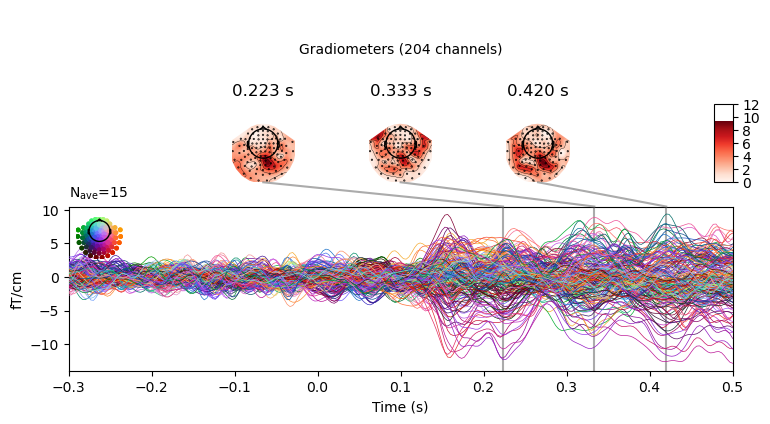

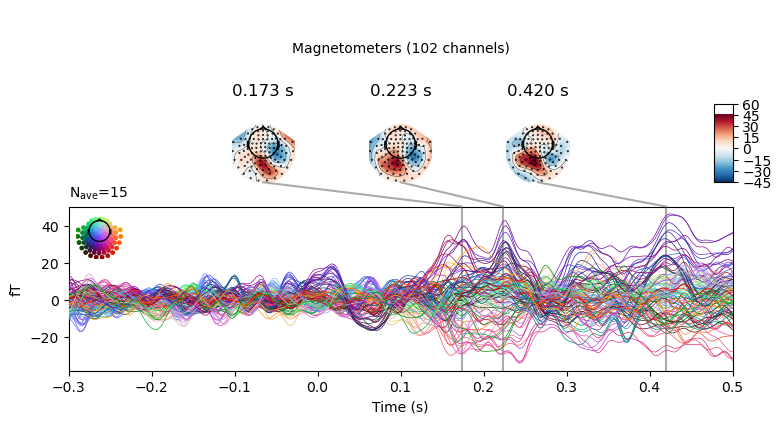

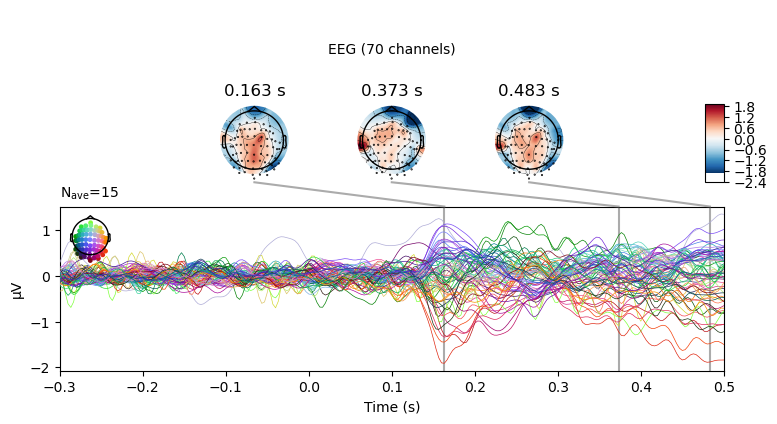

In [36]:
evoked_gave = mne.grand_average(contrast_list)
evoked_gave.plot_joint();

## Let's do some statistics - cluster-permutation test on one channel

We'll start with a single channel, EEG065. 

We will run a cluster-permutation test of our contrast against 0.

Let's start with the setup.

In [37]:
# imports for the statistics

import scipy as sp
from mne.stats import permutation_cluster_1samp_test

Let's get our data into a numpy array so we can feed it to the stats function.

In [38]:
channel = 'EEG065'
ch_idx = contrast.ch_names.index(channel)
data = np.array([c.data[ch_idx] for c in contrast_list])

Now, let's set some parameters for our test:

In [39]:
n_jobs = 2  # number of parallel jobs, you might want to set this to 1
n_permutations = 5000  # number of permutations to run 

# specify adjacency of points in the data: 
# here, no special adjacency is needed because it's only one channel and MNE will now
# just assume a regular grid, which is fine for our time dimension
adjacency = None  

tail = 0.  # we will run a two-sided test

Okay, with that out of the way, let's set our cluster thresholds:

In [40]:
# set the p-value we want to conduct our test at
p_value = 0.05

# Now, let's compute the threshold for our t-value - we need to pass that to the 
# stats function.
# Beware, that this changes for a one-sided test!
deg_of_free = len(data) - 1
threshold = sp.stats.t.ppf(1 - p_value/ (1 + (tail == 0)), deg_of_free)

Now we have everything to run our statistics!

In [41]:

cluster_stats = permutation_cluster_1samp_test(
    data, 
    threshold=threshold, 
    n_jobs=n_jobs, 
    verbose=True, 
    tail=tail,
    adjacency=adjacency,
    n_permutations=n_permutations, 
    seed=42)

T_obs, clusters, cluster_p_values, _ = cluster_stats

stat_fun(H1): min=-6.783906 max=1.635025
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

#### Visualize results from one-channel test

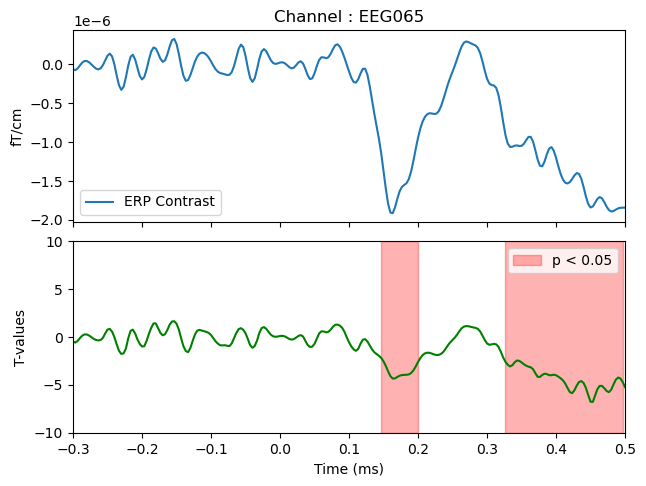

In [42]:
# set up the figure:
fig, axes = plt.subplots(2, sharex=True)

# on first axis: plot the data (contrast averaged across datasets)
ax = axes[0]
ax.plot(contrast.times, data.mean(axis=0), label='ERP Contrast')
ax.set(title='Channel : ' + channel, ylabel='fT/cm')
ax.legend()

# on second axis:
ax = axes[1]
# enumerate across the clusters
for ii, cluster_ii in enumerate(clusters):
    c = cluster_ii[0]

    # check if the matching p-value is smaller than the threshold:
    if cluster_p_values[ii] < p_value:
        # if so, mark the stretch of time:
        h1 = ax.axvspan(contrast.times[c[0]], 
                        contrast.times[c[-1] - 1],
                        color='r', alpha=0.3)

# plot the t-values 
hf = ax.plot(contrast.times, T_obs, 'g')

# set legend, axes, and show
ax.legend((h1,), (u'p < %s' % p_value,), loc='upper right', ncol=1)
ax.set(xlabel='Time (ms)', ylabel='T-values',
       ylim=[-10., 10.], xlim=contrast.times[[0, -1]])
fig.tight_layout(pad=0.5)
plt.show()

## Cluster-permutation test across time and sensors

Now let's not choose a sensor, but run the clustering approach across all _magnetometers_!

In [43]:
# here we can use a convenience function for spatio-temporal data:
from mne.stats import spatio_temporal_cluster_1samp_test

In [44]:
# let's use magnetometers here:
ch_type = 'mag'

# We again need to make our data into an array 
data = np.array([c.copy().pick_types(meg=ch_type).data
                 for c in contrast_list])

data.shape


(15, 102, 241)

The clustering function tells us:
```
X : array, shape (n_observations, p[, q], n_vertices)
    The data to be clustered. The first dimension should correspond to the
    difference between paired samples (observations) in two conditions.
    The second, and optionally third, dimensions correspond to the
    time or time-frequency data. And, the last dimension should be spatial.
```

In [45]:
# Make sure spatial dimension is last:
data = np.transpose(data, (0, 2, 1)) 
data.shape

(15, 241, 102)

Now our parameters again. This time we need to pay close attentiont to the adjacency!

In [46]:
# tail and cluster thresholds
tail = 0.  # for two sided test

# set cluster threshold (see above for more detail)
deg_of_free = len(data) - 1
threshold = sp.stats.t.ppf(1 - p_value/ (1 + (tail == 0)), deg_of_free)

# Make a triangulation between MEG sensor locations to
# use as adjacency informatiom for cluster level stats:
adjacency = mne.channels.find_ch_adjacency(contrast.info, ch_type)[0]

In [47]:

cluster_stats = spatio_temporal_cluster_1samp_test(
    data, 
    threshold=threshold, 
    n_jobs=2, 
    verbose=True, 
    tail=tail,
    adjacency=adjacency, 
    out_type='indices',
    check_disjoint=True, 
    seed=42)


stat_fun(H1): min=-6.677872 max=5.276830
No disjoint adjacency sets found
Running initial clustering …
Found 70 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

In [48]:
# Let's make the output easier to use for plotting:
T_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < 0.05)[0]

print("Good clusters: %i" % len(good_cluster_inds))

Good clusters: 2


#### Visualize the spatio-temporal clusters

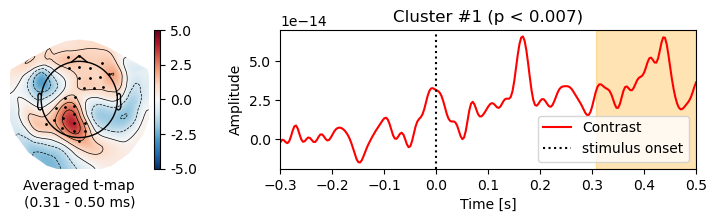

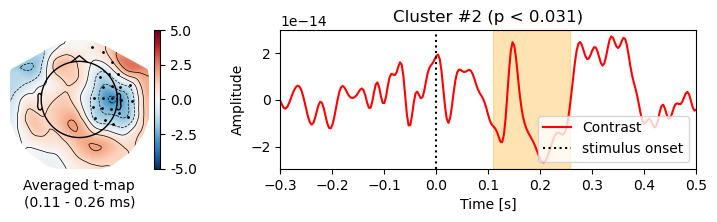

In [49]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.viz import plot_topomap

# some setup for plotting
colors = 'r', 'steelblue'
linestyles = '-', '--'

# find the relevant sensors
pos = mne.find_layout(contrast.info, ch_type=ch_type).pos

T_obs_max = 5.
T_obs_min = -T_obs_max

# loop over significant clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):

    # unpack cluster information, get unique indices per cluster
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # get topography for stats and average across time
    T_obs_map = T_obs[time_inds, ...].mean(axis=0)

    # get signals at significant sensors and average across sensors
    signals = data[..., ch_inds].mean(axis=-1)
    sig_times = contrast.times[time_inds]

    # create a spatial mask
    mask = np.zeros((T_obs_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(7, 2.))

    # how to mark sensors in the cluster
    mask_params = dict(marker='.', markerfacecolor='k', markersize=2)

    # plot average test statistic and mark significant sensors
    sel = mne.pick_types(contrast.info, meg=ch_type)
    info = mne.pick_info(contrast.info, sel)
    image, _ = plot_topomap(T_obs_map, info, ch_type=ch_type, mask=mask, 
                            axes=ax_topo, sensors=False,
                            mask_params=mask_params,
                            vmin=T_obs_min, vmax=T_obs_max,
                            show=False)

    # advanced matplotlib for showing image with figure and colorbar
    # in one plot
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar, add colorbar 
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(image, cax=ax_colorbar, format='%0.1f')

    # label the topoplot
    ax_topo.set_xlabel('Averaged t-map\n({:0.2f} - {:0.2f} ms)'.format(
        *sig_times[[0, -1]]
    ))

    # add a new axis for time courses and plot time courses
    ax_signals = divider.append_axes('right', size='300%', pad=1.2)
    for signal, name, col, ls in zip(signals, ['Contrast'], colors,
                                     linestyles):
        ax_signals.plot(contrast.times, signal, color=col,
                        linestyle=ls, label=name)

    # mark stimulus onset
    ax_signals.axvline(0, color='k', linestyle=':', label='stimulus onset')

    # adjust and label axes
    ax_signals.set_xlim([contrast.times[0], contrast.times[-1]])
    ax_signals.set_xlabel('Time [s]')
    ax_signals.set_ylabel('Amplitude')

    # plot the significant time range in time course
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                             color='orange', alpha=0.3)
    ax_signals.legend(loc='lower right')
    title = 'Cluster #{0} (p < {1:0.3f})'.format(i_clu + 1, p_values[clu_idx])
    ax_signals.set(ylim=[ymin, ymax], title=title)

    # clean up the figure a little
    fig.tight_layout(pad=0.5, w_pad=0)
    fig.subplots_adjust(bottom=.05)

plt.show()

#### Further reading and credit:

The code in this notebook is heavily inspired by https://github.com/mne-tools/mne-biomag-group-demo/tree/master/scripts/results/statistics

More about sensor level statistics can be found here: https://mne.tools/stable/auto_tutorials/stats-sensor-space/index.html

If you want to do stats in source space, check this: https://mne.tools/stable/auto_tutorials/stats-source-space/index.html